<a href="https://colab.research.google.com/github/thejd777/A_B_testing_CR/blob/main/A_B_testing_CR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключаем необходимые библиотеки  
Import required libriries  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
from google.colab import files
import io

import statsmodels.stats.api as sms
from math import ceil

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Загружаем файлы с данными и помещаем эти данные в переменные типа датафрейм(или сириес) библиотеки пандас  
Download files with data and put the data into variables  
data1_1 - эксперимент 1, группа A (first experiment, A group)  
data1_2 - эксперимент 1, группа B (first experiment, B group)  
data2_1 - эксперимент 2, группа A (second experiment, A group)   
data2_2 - эксперимент 2, группа B (second experiment, B group)   

In [ ]:
uploaded=files.upload()
data1_1 = pd.read_csv(io.StringIO(uploaded['experiment1_1.csv'].decode('utf-8')),sep=',')
data1_2 = pd.read_csv(io.StringIO(uploaded['experiment1_2.csv'].decode('utf-8')),sep=',')
data2_1 = pd.read_csv(io.StringIO(uploaded['experiment2_1.csv'].decode('utf-8')),sep=',')
data2_2 = pd.read_csv(io.StringIO(uploaded['experiment2_2.csv'].decode('utf-8')),sep=',')

## Объявляем переменные и описываем функции  
## Declare variables and describe functions  

In [158]:
alfa = 0.05

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def pieOfPayments(data):
  values = np.unique(data, return_counts=True)[1]
  labels = np.unique(data, return_counts=True)[0]
  labels = np.core.defchararray.add(labels.astype('str'), ' payment(s) per day')

  fig, ax = plt.subplots(figsize=(10,10))

  ax.set_title('Count of payments per day', color='blue', fontweight='bold', fontsize=16)
  wedges, texts, autotexts = ax.pie(values, autopct=make_autopct(values), textprops=dict(color='white', weight='bold'))

  fig.legend(wedges, labels, title='Payments count', loc='upper right')
  fig.set_facecolor('lightgrey')

  return plt.show()

def twoPiesOfPayments(data1, data2):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
  
  values1 = np.unique(data1, return_counts=True)[1]
  labels1 = np.unique(data1, return_counts=True)[0]
  labels1 = np.core.defchararray.add(labels1.astype('str'), ' payment(s) per day')
  ax1.set_title('Group 1', color='black', fontweight='bold', fontsize=16)
  ax1.pie(values1, labels=labels1, autopct=make_autopct(values1), textprops=dict(color='white', weight='bold'))

  values2 = np.unique(data2, return_counts=True)[1]
  labels2 = np.unique(data2, return_counts=True)[0]
  labels2 = np.core.defchararray.add(labels2.astype('str'), ' payment(s) per day')
  ax2.set_title('Group 2', color='black', fontweight='bold', fontsize=16)
  ax2.pie(values2, labels=labels2, autopct=make_autopct(values2), textprops=dict(color='white', weight='bold'))

  fig.set_facecolor('grey')
  fig.suptitle('Count of payments per day', color='white', fontsize=18, weight='bold')

  return plt.show()

def twoBarsOfConfInterval(data1, data2):
  data1CrAvg = data1.sum() / data1.size
  data2CrAvg = data2.sum() / data2.size

  data1CrStandardDiviation = np.sqrt(((data1 - data1CrAvg)**2).sum() / (data1.size-1))
  data2CrStandardDiviation = np.sqrt(((data2 - data2CrAvg)**2).sum() / (data2.size-1))

  data1StartConfInt = data1CrAvg - ( (1-alfa/2) * data1CrStandardDiviation )
  data2StartConfInt = data2CrAvg - ( (1-alfa/2) * data2CrStandardDiviation )

  data1EndConfInt = data1CrAvg + ( (1-alfa/2) * data1CrStandardDiviation )
  data2EndConfInt = data2CrAvg + ( (1-alfa/2) * data2CrStandardDiviation )

  labels = ('Group 1', 'Group 2')

  width1 = abs(data1EndConfInt - data1StartConfInt)
  width2 = abs(data2EndConfInt - data2StartConfInt)
  #startX = (data1StartConfInt + data2StartConfInt) / 2
  #endX = (data1EndConfInt + data2EndConfInt) / 2
  startX = data1StartConfInt if data1StartConfInt < data2StartConfInt else data2StartConfInt
  endX = data1EndConfInt if data1EndConfInt > data2EndConfInt else data2EndConfInt
  #margin = (width1 + width2) / 2 * 0.2
  margin = 0.5

  fig, ax = plt.subplots(figsize=(15, 5))
  plt.xticks(np.arange(round(startX - margin, 1), round(endX + margin, 1), 0.2))

  wedg1 = ax.barh(y=1, left=data1StartConfInt, width=width1)
  wedg2 = ax.barh(y=-1, left=data2StartConfInt, width=width2)
  ax.margins(y=0.5)
  ax.set_xlim(xmin=startX - margin, xmax=endX + margin)

  fig.suptitle('Confidence intervals', fontsize=20)
  fig.legend((wedg1, wedg2), labels, loc='upper right')

  return plt.show

# Эксперимент 1  
# First experiment  

Очищаем исходные данные от дубликатов  
Drop duplicates from data  

In [159]:
data1_1NoDuplicates = data1_1.drop_duplicates()
data1_2NoDuplicates = data1_2.drop_duplicates()

Меняем тип данных в колонке 'timestamp' c 'str' на 'timestamp'  
Change data type from 'str' to 'timestamp' for 'timestamp' column  

In [ ]:
data1_1NoDuplicates['timestamp'] = pd.to_datetime(data1_1NoDuplicates['timestamp'])
data1_2NoDuplicates['timestamp'] = pd.to_datetime(data1_2NoDuplicates['timestamp'])

Упорядочим данные по временной метке  
Sort data by timestamp  

In [161]:
data1_1NoDuplicates = data1_1NoDuplicates.sort_values('timestamp')
data1_2NoDuplicates = data1_2NoDuplicates.sort_values('timestamp')

Пометим конверсионные действия  
Mark conversion actions  

In [162]:
data1_1NoDuplicates['conversion'] = np.where(data1_1NoDuplicates['event'] == 'payment_done', 1, 0)
data1_2NoDuplicates['conversion'] = np.where(data1_2NoDuplicates['event'] == 'payment_done', 1, 0)

Добавим колонку с датой  
Add date column  

In [163]:
data1_1NoDuplicates['date'] = pd.to_datetime(data1_1NoDuplicates.timestamp.dt.strftime('%Y-%m-%d'))
data1_2NoDuplicates['date'] = pd.to_datetime(data1_2NoDuplicates.timestamp.dt.strftime('%Y-%m-%d'))

Поместим в массив количество конверсий за каждый день (начиная с первого, по порядку)  
Put into array count of conversions for each day  

In [164]:
data1_1ConversionSumByDay = np.array(data1_1NoDuplicates[['date', 'conversion']].groupby('date').sum().conversion)
data1_2ConversionSumByDay = np.array(data1_2NoDuplicates[['date', 'conversion']].groupby('date').sum().conversion)

Построим круговую диаграмму с количеством коверсий в день, для каждой группы  
Build pie diagram with count of conversions per day for every group  

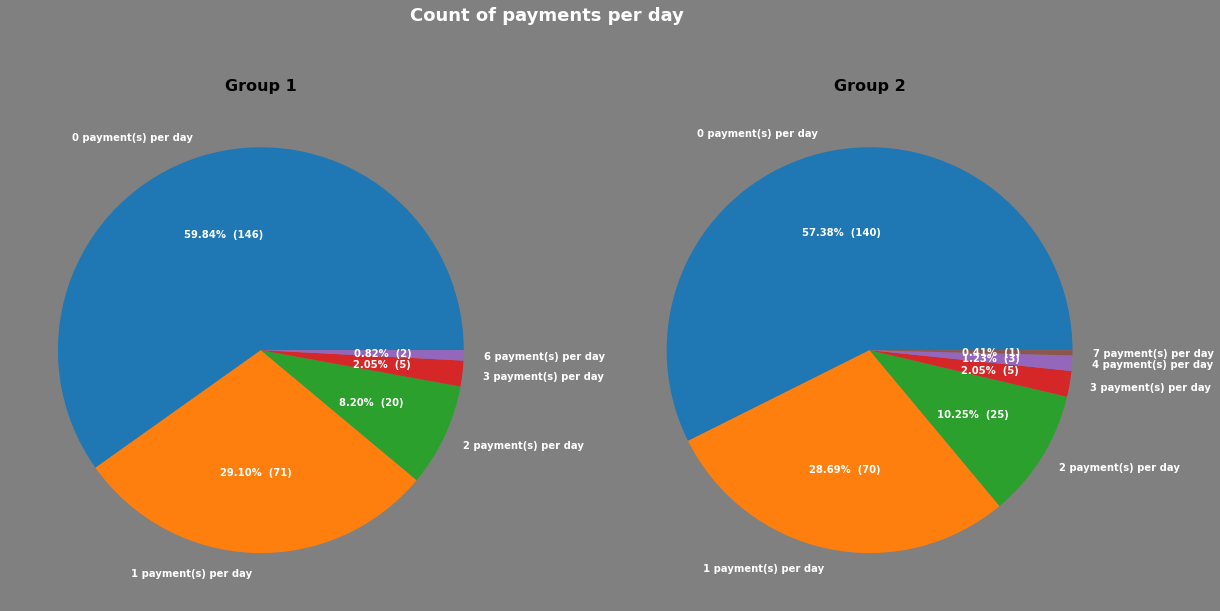

In [165]:
twoPiesOfPayments(data1_1ConversionSumByDay, data1_2ConversionSumByDay)

Считаем количество уникальных сессий для групп A и B  
Calculating count of unique sessions for A and B groups  

In [166]:
sessionCountA = data1_1NoDuplicates.session.agg(func='nunique')
sessionCountB = data1_2NoDuplicates.session.agg(func='nunique')
print(sessionCountA, sessionCountB)

40338 40532


Считаем количество конверсий  
Calculating count of conversion sessions  

In [167]:
crACount = data1_1NoDuplicates[data1_1NoDuplicates['event'] == 'payment_done'].shape[0]
crBCount = data1_2NoDuplicates[data1_2NoDuplicates['event'] == 'payment_done'].shape[0]
print(crACount, crBCount)

138 154


Считаем конверсию для групп и смотрим на разность конверсий  
Calculating conversion rate for groups and difference between CR  

In [168]:
crA =  crACount / sessionCountA
crB =  crBCount / sessionCountB
crDelta = crB - crA
print(crA, crB, crDelta)

0.003421091774505429 0.0037994670877331493 0.00037837531322772004


Видим незначительное увеличение конверсии  
Notice a little bit increase of CR  

Построим гистограмму с общим количеством сессий и с конверсионными сессиями, для наглядности данные пролагорифмируем  
Build a histogram with count of all sessions and count of conversion sessions, for clarity, take the logarithm of the data  

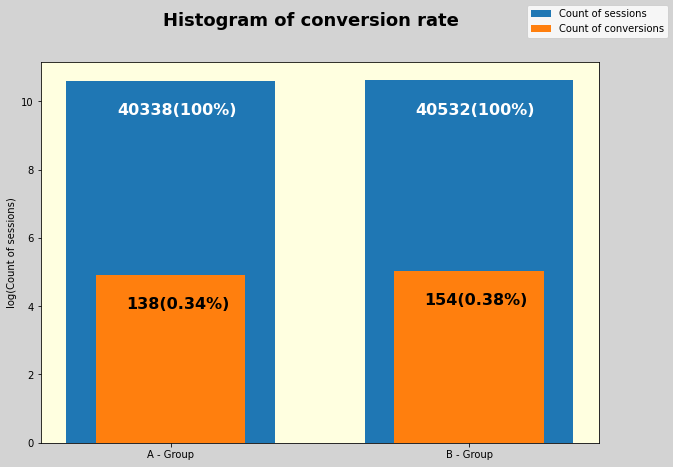

In [169]:
ySessionAll = np.array([sessionCountA, sessionCountB], dtype='int')
ySessionCR = np.array([crACount, crBCount], dtype='int')

xLable = np.array(['A - Group', 'B - Group'], dtype='str')

fig, ax = plt.subplots()

ax.set_ylabel('log(Count of sessions)')

ax.bar(xLable, np.log(ySessionAll), width=0.7)
ax.bar(xLable, np.log(ySessionCR), width=0.5)
ax.set_facecolor('lightyellow')
for i, val in enumerate(ySessionAll):
  ax.annotate(str(val)+'(100%)', xy=(i-0.18, np.log(val)-1), color='#fff', fontsize=16, fontweight=700)
for i, val in enumerate(ySessionCR):
  ax.annotate(str(val)+'('+str(np.around(ySessionCR[i]/ySessionAll[i]*100, decimals=2))+'%)', xy=(i-0.15, np.log(val)-1), color='#000', fontsize=16, fontweight='bold')

fig.set_figwidth(10, forward=False)
fig.set_figheight(7, forward=False)
fig.set_facecolor('lightgrey')
fig.legend(labels=['Count of sessions', 'Count of conversions'], loc='upper right')
fig.suptitle('Histogram of conversion rate', fontsize=18, fontweight=700, color='#000')

plt.show()

Теперь проверим, что количество выборки для групп достаточное для достоверного результата:  
Calculating sample size which needs for true result  

In [170]:
# Считаем размер эффекта, основываясь на ожидаемой конверсии
# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(crA, crB, method='normal')

# Считаем необходимый размер выборки
# Calculating sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )

# Округляем до целого, в большую сторону
# Rounding up to next whole number
required_n = ceil(required_n)
print(required_n)

394152


Получаем размер выборки - 394152 посещений для каждой группы.  
Это не удовлетваряет нашим группам, где в каждой около 40500 посещений.  
We've got sample size equally 394152, it isn't suit for our groups  

Считаем сессии без конверсии  
Calculating non conversion sessions  

In [171]:
sessionNoCrA = sessionCountA - crACount
sessionNoCrB = sessionCountB - crBCount
print(sessionNoCrA, sessionNoCrB)

40200 40378


Считаем конверсию для объединенной группы A + B  
Calculating CR for union of groups  

In [172]:
crMean = (crACount + crBCount) / (sessionCountA + sessionCountB)
crMean

0.0036107332756275504

Считаем сколько было бы конверсионных и неконверсионных сессий, если конверсия была бы как у объединенной группы  
Calculating conversion and non conversion sessions with union of groups CR  

In [173]:
sessionCrMeanA = sessionCountA * crMean
sessionCrMeanB = sessionCountB * crMean

sessionNoCrMeanA = sessionCountA - sessionCrMeanA
sessionNoCrMeanB = sessionCountB - sessionCrMeanB
print(sessionCrMeanA, sessionCrMeanB, sessionNoCrMeanA, sessionNoCrMeanB)

145.64975887226413 146.35024112773587 40192.35024112774 40385.64975887226


Построим доверительные интервалы для двух групп  
Build confidence intervals for two groups  

<function matplotlib.pyplot.show>

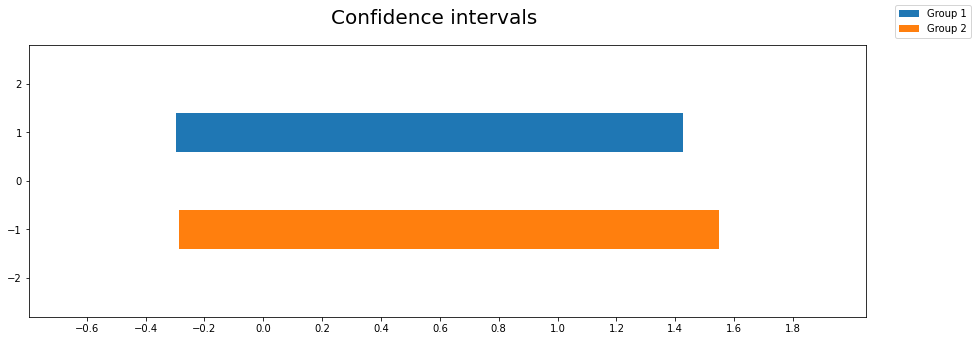

In [174]:
twoBarsOfConfInterval(data1_1ConversionSumByDay, data1_2ConversionSumByDay)

Из графика видим, что группы с большой долей вероятности относятся к одному распределению  
We notice from plot that both of groups belong to the same distribution 

По формуле вычисляем вероятность того, что в группе B было статистически значимое улучшение конверсии и нуль-гипотеза может быть отвергнута  
Calculating probability of statistical significance  

In [175]:
O = np.array([crACount, crBCount, sessionNoCrA, sessionNoCrB])
T = np.array([sessionCrMeanA, sessionCrMeanB, sessionNoCrMeanA, sessionNoCrMeanB])
D = np.sum(np.square(T-O)/T)
pVal = sps.chi2.sf(D, df=1)

print("distance d: {0}\np-value: {1}". format(D, pVal))

distance d: 0.8045371274499714
p-value: 0.3697402956393102


Исходя из полученных данных мы видим, что нуль-гипотеза не может быть отвергнута с вероятностью около 37%  
Based on the recive data, H0 can't be reject with a probability about 37%  

# Эксперимент 2  
# Second experiment  

Очищаем исходные данные от дубликатов  
Drop duplicates from data  

In [176]:
data2_1NoDuplicates = data2_1.drop_duplicates()
data2_2NoDuplicates = data2_2.drop_duplicates()

Меняем тип данных в колонке 'timestamp' c 'str' на 'timestamp'  
Change data type from 'str' to 'timestamp' for 'timestamp' column  

In [ ]:
data2_1NoDuplicates['timestamp'] = pd.to_datetime(data2_1NoDuplicates['timestamp'])
data2_2NoDuplicates['timestamp'] = pd.to_datetime(data2_2NoDuplicates['timestamp'])

Упорядочим данные по временной метке  
Sort data by timestamp  

In [178]:
data2_1NoDuplicates = data2_1NoDuplicates.sort_values('timestamp')
data2_2NoDuplicates = data2_2NoDuplicates.sort_values('timestamp')

Пометим конверсионные действия  
Mark conversion actions  

In [179]:
data2_1NoDuplicates['conversion'] = np.where(data2_1NoDuplicates['event'] == 'payment_done', 1, 0)
data2_2NoDuplicates['conversion'] = np.where(data2_2NoDuplicates['event'] == 'payment_done', 1, 0)

Добавим колонку с датой  
Add date column  

In [180]:
data2_1NoDuplicates['date'] = pd.to_datetime(data2_1NoDuplicates.timestamp.dt.strftime('%Y-%m-%d'))
data2_2NoDuplicates['date'] = pd.to_datetime(data2_2NoDuplicates.timestamp.dt.strftime('%Y-%m-%d'))

Поместим в массив количество конверсий за каждый день (начиная с первого, по порядку)  
Put into array count of conversions for each day  

In [181]:
data2_1ConversionSumByDay = np.array(data2_1NoDuplicates[['date', 'conversion']].groupby('date').sum().conversion)
data2_2ConversionSumByDay = np.array(data2_2NoDuplicates[['date', 'conversion']].groupby('date').sum().conversion)

Построим круговую диаграмму с количеством коверсий в день, для каждой группы  
Build pie diagram with count of conversions per day for every group  

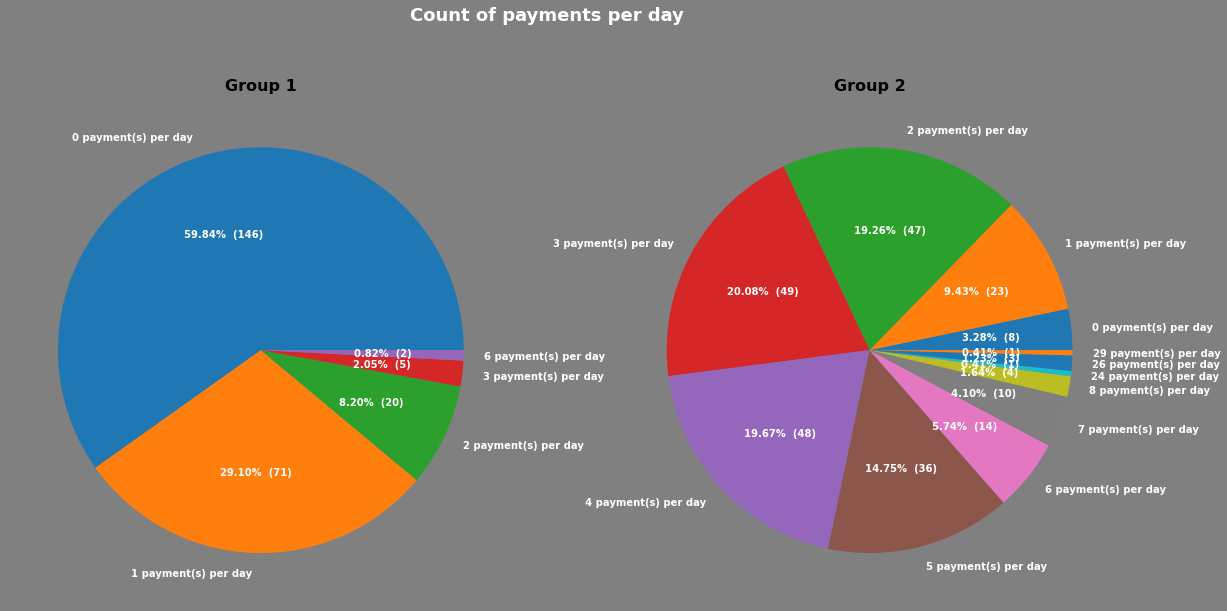

In [182]:
twoPiesOfPayments(data2_1ConversionSumByDay, data2_2ConversionSumByDay)

Считаем количество уникальных сессий для групп A и B  
Calculating count of unique sessions for A and B groups  

In [183]:
sessionCountA2 = data2_1NoDuplicates.groupby('session').count().shape[0]
sessionCountB2 = data2_2NoDuplicates.groupby('session').count().shape[0]
print(sessionCountA2, sessionCountB2)

40338 40219


Считаем количество конверсий  
Calculating count of conversion sessions  

In [184]:
crA2Count = data2_1NoDuplicates[data2_1NoDuplicates['event'] == 'payment_done'].shape[0]
crB2Count = data2_2NoDuplicates[data2_2NoDuplicates['event'] == 'payment_done'].shape[0]
print(crA2Count, crB2Count)

138 953


Считаем конверсию для групп и смотрим на разность конверсий  
Calculating conversion rate for groups and difference between CR  

In [185]:
crA2 =  crA2Count / sessionCountA2
crB2 =  crB2Count / sessionCountB2
cr2Delta = crB2 - crA2
print(crA2, crB2, cr2Delta)

0.003421091774505429 0.023695268405479995 0.020274176630974566


Видим увеличение конверсии около 2%  
Notice increase of CR about 2%    

Построим гистограмму с общим количеством сессий и с конверсионными сессиями, для наглядности данные пролагорифмируем  
Build a histogram with count of all sessions and count of conversion sessions, for clarity, take the logarithm of the data  

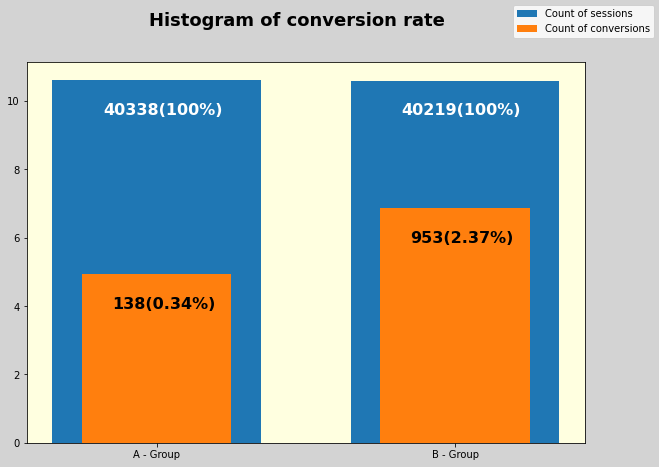

In [186]:
ySessionAll2 = np.array([sessionCountA2, sessionCountB2], dtype='int')
ySessionCR2 = np.array([crA2Count, crB2Count], dtype='int')

xLable = np.array(['A - Group', 'B - Group'], dtype='str')

fig, ax = plt.subplots()

ax.bar(xLable, np.log(ySessionAll2), width=0.7)
ax.bar(xLable, np.log(ySessionCR2), width=0.5)
ax.set_facecolor('lightyellow')
for i, val in enumerate(ySessionAll2):
  ax.annotate(str(val)+'(100%)', xy=(i-0.18, np.log(val)-1), color='#fff', fontsize=16, fontweight=700)
for i, val in enumerate(ySessionCR2):
  ax.annotate(str(val)+'('+str(np.around(ySessionCR2[i]/ySessionAll2[i]*100, decimals=2))+'%)', xy=(i-0.15, np.log(val)-1), color='#000', fontsize=16, fontweight='bold')

fig.set_figwidth(10, forward=False)
fig.set_figheight(7, forward=False)
fig.set_facecolor('lightgrey')
fig.legend(labels=['Count of sessions', 'Count of conversions'], loc='upper right')
fig.suptitle('Histogram of conversion rate', fontsize=18, fontweight=700, color='#000')

plt.show()

Теперь проверим, что количество выборки для групп достаточное для достоверного результата:  
Calculating sample size which needs for true result  

In [187]:
# Считаем размер эффекта, основываясь на ожидаемой конверсии
# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(crA2, crB2, method='normal')

# Считаем необходимый размер выборки
# Calculating sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )

# Округляем до целого, в большую сторону
# Rounding up to next whole number
required_n = ceil(required_n)
print(required_n)

426


Получаем размер выборки - 426 посещений для каждой группы.  
Это удовлетваряет нашим группам, где в каждой около 40000 посещений.  
We've got sample size equally 426, it's suit for our groups  

Считаем сессии без конверсии  
Calculating non conversion sessions  

In [188]:
sessionNoCrA2 = sessionCountA2 - crA2Count
sessionNoCrB2 = sessionCountB2 - crB2Count
print(sessionNoCrA2, sessionNoCrB2)

40200 39266


Считаем конверсию для объединенной группы A + B  
Calculating CR for union of groups  

In [189]:
crMean2 = (crA2Count + crB2Count) / (sessionCountA2 + sessionCountB2)
crMean2

0.013543205432178457

Считаем сколько было бы конверсионных и неконверсионных сессий, если конверсия была бы как у объединенной группы  
Calculating conversion and non conversion sessions with union of groups CR  

In [190]:
sessionCrMeanA2 = sessionCountA2 * crMean2
sessionCrMeanB2 = sessionCountB2 * crMean2

sessionNoCrMeanA2 = sessionCountA2 - sessionCrMeanA2
sessionNoCrMeanB2 = sessionCountB2 - sessionCrMeanB2
print(sessionCrMeanA2, sessionCrMeanB2, sessionNoCrMeanA2, sessionNoCrMeanB2)

546.3058207232147 544.6941792767853 39791.69417927678 39674.30582072322


Построим доверительные интервалы для двух групп  
Build confidence intervals for two groups  

<function matplotlib.pyplot.show>

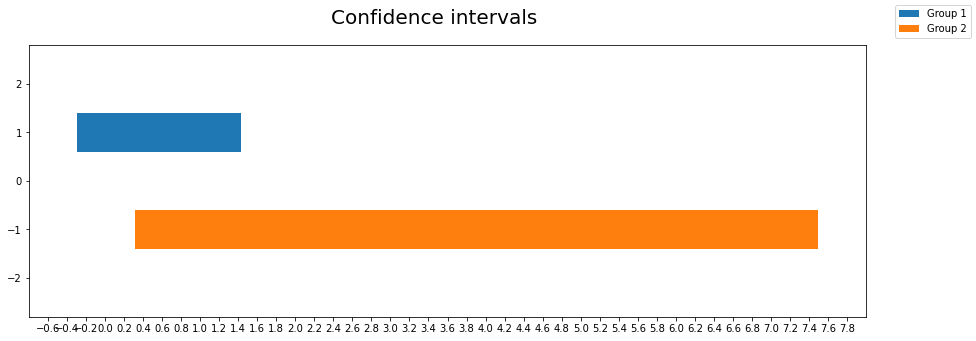

In [191]:
twoBarsOfConfInterval(data2_1ConversionSumByDay, data2_2ConversionSumByDay)

Из графика видим, что группы с большой долей вероятности относятся к разным распределениям  
We notice from plot that both of groups belong to the difference distributions  

По формуле вычисляем вероятность того, что в группе B было статистически значимое улучшение конверсии и нуль-гипотеза может быть отвергнута  
Calculating probability of statistical significance  

In [192]:
O2 = np.array([crA2Count, crB2Count, sessionNoCrA2, sessionNoCrB2])
T2 = np.array([sessionCrMeanA2, sessionCrMeanB2, sessionNoCrMeanA2, sessionNoCrMeanB2])
D2 = np.sum(np.square(T2-O2)/T2)
pVal2 = sps.chi2.sf(D2, df=1)

print("distance d: {0}\np-value: {1}". format(D2, pVal2))

distance d: 619.6254713603117
p-value: 9.020192551074774e-137


Исходя из полученных данных мы видим, что нуль-гипотеза не может быть отвергнута с вероятностью 902*10^-37%, то есть вероятность того, что тестовая и контрольная группы являются множествами одного распределения крайне мала.  
Также принимая во внимание, что размер выборки нас удовлетваряет и наблюдается прирост конверсии около 2% в абсолютной величине, то можем сделать вывод что можно вводить новую версию сайта в продакшн.  
Based on the recive data, H0 can be reject with a high probability  